In [1]:
import pandas as pd
import numpy as np

import time

# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline 

import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set(font_scale=1.5)

# import the ML algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBRFClassifier
#import sys
#!{sys.executable} -m pip install xgboost

# import libraries for model validation
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut

# import libraries for metrics and reporting
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Loading Data

movies = pd.read_csv('E:\\Simplilearn\\Data Science with Python\\Projects\\Movielens\\Data\\movies.dat', sep = "::", names = ['MovieID', 'Title', 'Genres'], engine='python')
ratings = pd.read_csv('E:\\Simplilearn\\Data Science with Python\\Projects\\Movielens\\Data\\ratings.dat', sep = "::", names = ['UserID','MovieID', 'Rating', 'Timestamp'], engine='python')
users = pd.read_csv('E:\\Simplilearn\\Data Science with Python\\Projects\\Movielens\\Data\\users.dat', sep = "::", names = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-Code'], engine='python')

In [3]:
#Describing the data

print(movies.head())
print('\nNumber of rows in movies df  : ', movies.shape,'\n')
print(ratings.head())
print('\nNumber of rows in ratings  df  : ', ratings.shape,'\n')
print(users.head())
print('\nNumber of rows in users df : ', users.shape)

   MovieID                               Title                        Genres
0        1                    Toy Story (1995)   Animation|Children's|Comedy
1        2                      Jumanji (1995)  Adventure|Children's|Fantasy
2        3             Grumpier Old Men (1995)                Comedy|Romance
3        4            Waiting to Exhale (1995)                  Comedy|Drama
4        5  Father of the Bride Part II (1995)                        Comedy

Number of rows in movies df  :  (3883, 3) 

   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291

Number of rows in ratings  df  :  (1000209, 4) 

   UserID Gender  Age  Occupation Zip-Code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460


In [4]:
#merging the three datasets to create Master_Data

temp_data= pd.merge(ratings,users, on= 'UserID', how='left')
master_data = pd.merge(temp_data,movies, on= 'MovieID',how='left')

In [5]:
print(master_data.head(),'\n\n')
print(master_data.info())

   UserID  MovieID  Rating  Timestamp Gender  Age  Occupation Zip-Code  \
0       1     1193       5  978300760      F    1          10    48067   
1       1      661       3  978302109      F    1          10    48067   
2       1      914       3  978301968      F    1          10    48067   
3       1     3408       4  978300275      F    1          10    48067   
4       1     2355       5  978824291      F    1          10    48067   

                                    Title                        Genres  
0  One Flew Over the Cuckoo's Nest (1975)                         Drama  
1        James and the Giant Peach (1996)  Animation|Children's|Musical  
2                     My Fair Lady (1964)               Musical|Romance  
3                  Erin Brockovich (2000)                         Drama  
4                    Bug's Life, A (1998)   Animation|Children's|Comedy   


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 0 to 1000208
Data columns (total 10 colum

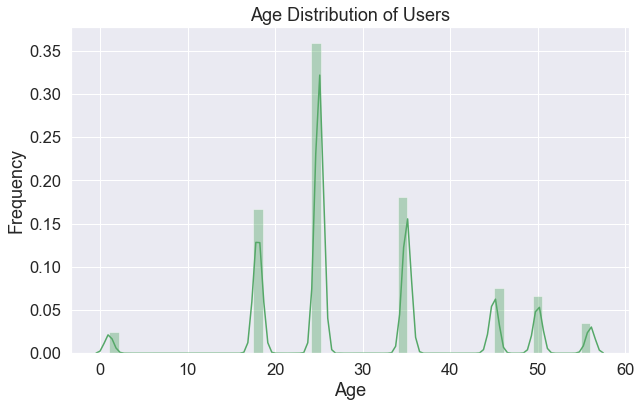

In [6]:
#Explore the datasets using visual representations (graphs or tables), also include your comments on the following:
#1. User Age Distribution 

plt.figure(figsize=[10,6])
sns.distplot(master_data.Age,color='g')
plt.title('Age Distribution of Users')
plt.ylabel('Frequency')
plt.xlabel('Age');

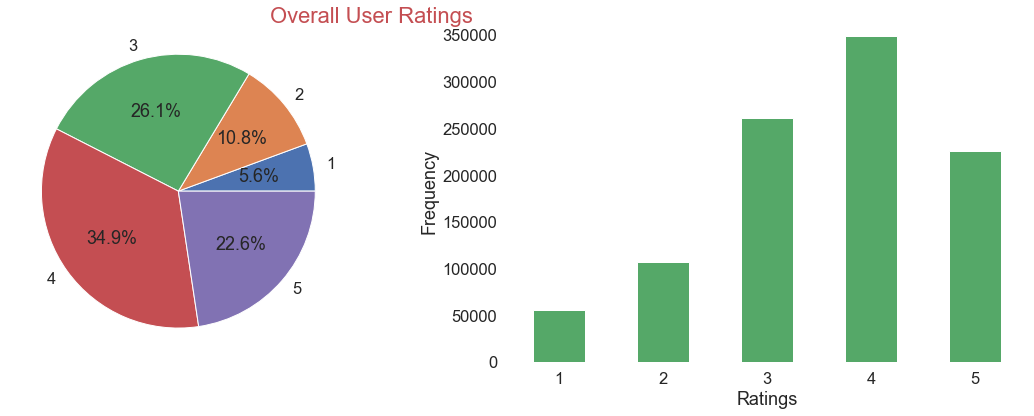

In [7]:
#Overall ratings by users

fig,ax= plt.subplots(1,2,figsize=[16,6])
pd.value_counts(master_data.Rating).sort_index().plot.pie(autopct='%.1f%%',ax=ax[0],labels=[1,2,3,4,5])
ax[0].set(ylabel= '')

pd.value_counts(master_data.Rating).sort_index().plot(kind='bar',color='g',rot=0,ax=ax[1])
ax[1].set(xlabel='Ratings', ylabel='Frequency')
plt.tight_layout(pad=1.2)
plt.box(False)
fig.suptitle('Overall User Ratings',ha='right',color='r',fontsize=22);

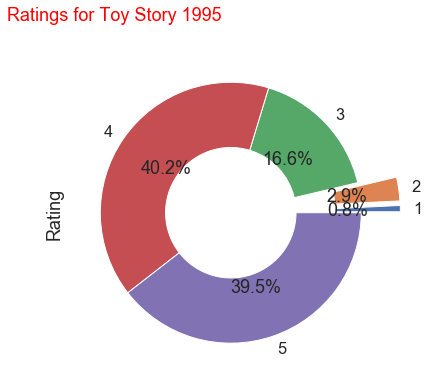

In [8]:
#2. User rating of the movie “Toy Story”

plt.figure(figsize=[10,6])

Toy_Story_Ratings = master_data[master_data.MovieID.isin([1])].Rating.value_counts()

plt.suptitle('Ratings for Toy Story 1995', fontsize=18, color='red', ha='right')
Toy_Story_Ratings.sort_index().plot(kind='pie',autopct='%.1f%%',labels=[1,2,3,4,5],explode=(0.3,0.3,0,0,0),wedgeprops=dict(width=.5))
plt.rcParams['font.size'] = 10

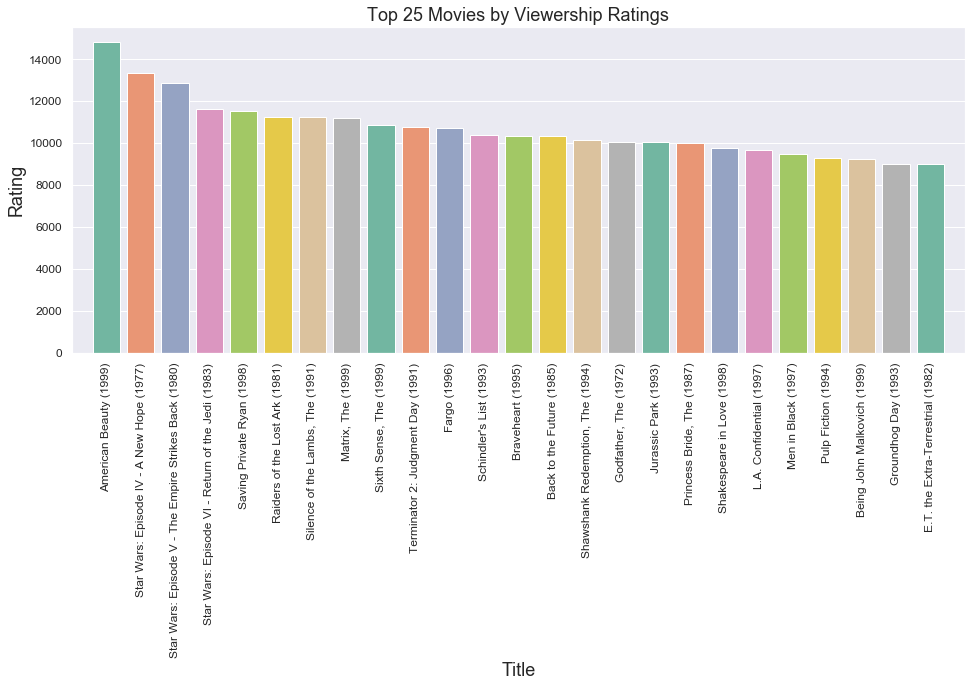

In [9]:
#3. Top 25 movies by viewership rating 

top_25_movies_by_user_ratings = \
master_data.groupby('Title').agg({\
                                  'Rating':'sum'\
                                 }).sort_values(by='Rating',ascending=False).reset_index()

plt.figure(figsize=[16,6])
sns.barplot('Title','Rating',data=top_25_movies_by_user_ratings[:25],palette='Set2')
plt.xticks(rotation=90, size = 12)
plt.yticks(size = 12)
plt.title('Top 25 Movies by Viewership Ratings')
plt.xlim((-1,25));

Text(0, 0.5, 'Rating counts')

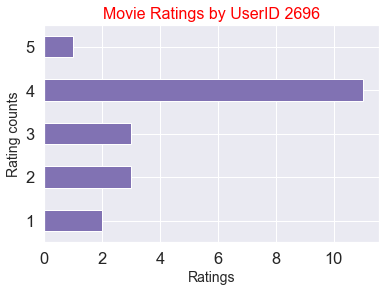

In [10]:
#4. Find the ratings for all the movies reviewed by for a particular user of user id = 2696

rating_by_user_2696 = master_data[master_data.UserID == 2696][['UserID','Rating']].reset_index(drop=True)

rating_by_user_2696.Rating.value_counts().sort_index().plot(kind='barh',rot=0,color='m')
plt.title('Movie Ratings by UserID 2696', size=16, color='red')
plt.xlabel('Ratings', size=14)
plt.ylabel('Rating counts', size=14)

In [11]:
#Feature Engineering: 

#Use column genres:

#1. Find out all the unique genres (Hint: split the data in column genre making a list and then process the data to 
#find out only the unique categories of genres)

master_data['Genres'] = master_data.Genres.apply(lambda x: x.split('|'))

In [12]:
%%time
genre_list= []
for genres in master_data.Genres.values:
    for genre in genres:
        genre_list.append(genre)

Wall time: 461 ms


In [13]:
unique_genre = set(genre_list)
print('The unique Genres are: [{}]'.format(unique_genre))

The unique Genres are: [{'Thriller', 'Comedy', "Children's", 'Animation', 'Crime', 'Musical', 'Action', 'Sci-Fi', 'Mystery', 'Drama', 'War', 'Film-Noir', 'Romance', 'Western', 'Adventure', 'Fantasy', 'Documentary', 'Horror'}]


In [14]:
#2. Create a separate column for each genre category with a one-hot encoding ( 1 and 0) whether or not the movie 
#belongs to that genre.

In [15]:
%%time
for genre in unique_genre:
    master_data[genre] = master_data.Genres.apply(lambda x: 1 if genre in x else 0)

Wall time: 9.87 s


In [16]:
master_data.head(2)

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-Code,Title,Genres,...,Mystery,Drama,War,Film-Noir,Romance,Western,Adventure,Fantasy,Documentary,Horror
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),[Drama],...,0,1,0,0,0,0,0,0,0,0
1,1,661,3,978302109,F,1,10,48067,James and the Giant Peach (1996),"[Animation, Children's, Musical]",...,0,0,0,0,0,0,0,0,0,0


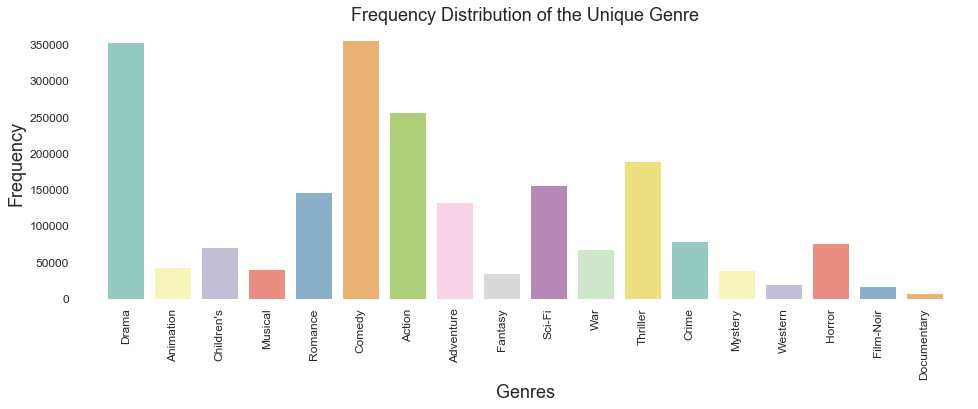

In [17]:
genres = pd.Series(np.array(genre_list)).to_frame(name='Genres')
plt.figure(figsize=[16,5])
sns.countplot('Genres',data=genres,palette='Set3')
plt.xticks(rotation=90, size = 12)
plt.yticks(size=12)
plt.xlim(-1,18)
plt.title('Frequency Distribution of the Unique Genre')
plt.ylabel('Frequency');
plt.box(False)

In [18]:
#3. Determine the features affecting the ratings of any particular movie. - will use MovieID, Age and Occupation

from scipy.stats import chi2_contingency

ctTitle = pd.crosstab(master_data.Title,master_data.Rating)
ctGender = pd.crosstab(master_data.Gender,master_data.Rating)
ctAge = pd.crosstab(master_data.Age,master_data.Rating)
ctOccupation = pd.crosstab(master_data.Occupation,master_data.Rating)
ctZipCode = pd.crosstab(master_data['Zip-Code'],master_data.Rating)

In [19]:
from scipy.stats import chi2_contingency

list1 = [ctTitle,ctGender,ctAge,ctOccupation,ctZipCode]

for i in list1:
    stat,pvalue,dof,expected_R = chi2_contingency(i)
    if pvalue <= 0.05:
        print("Alternate Hypothesis passed. {} and Rating have Relationship; pvalue = {:.5e}".format(i.index.name,pvalue))
    else:
        print("Null hypothesis passed. {} and Rating doesnot have  Relationship".format(i.index.name))

Alternate Hypothesis passed. Title and Rating have Relationship; pvalue = 0.00000e+00
Alternate Hypothesis passed. Gender and Rating have Relationship; pvalue = 2.34856e-97
Alternate Hypothesis passed. Age and Rating have Relationship; pvalue = 0.00000e+00
Alternate Hypothesis passed. Occupation and Rating have Relationship; pvalue = 0.00000e+00
Alternate Hypothesis passed. Zip-Code and Rating have Relationship; pvalue = 0.00000e+00


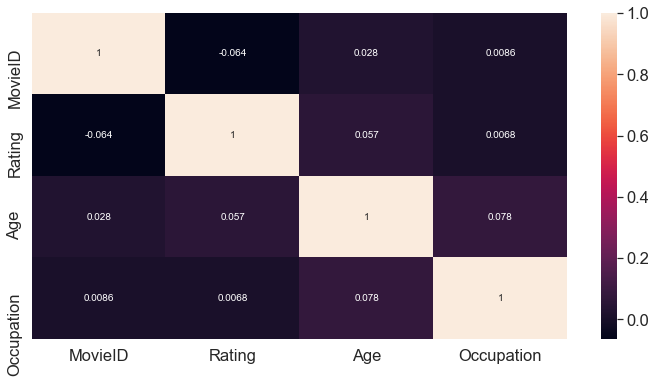

In [20]:
df = master_data[['MovieID','Rating', 'Gender','Age','Occupation', 'Zip-Code']]


plt.figure(figsize=(12,6))
corr=df.corr()
sns.heatmap(corr,xticklabels=corr.columns.values,yticklabels=corr.columns.values,annot=True,annot_kws={'size':10})

In [21]:
#4. Develop an appropriate model to predict the movie ratings - Will use the above information to do this

feature_cols = ['MovieID',
                'Age',
                'Occupation']

response_col = ['Rating']

X = master_data[feature_cols].values
y = master_data[response_col].values.ravel()

# Split into train and test sets.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state =0)

In [22]:
# Linear Regression

linreg=LinearRegression()
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)

# compute the RMSE of our predictions

print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(linreg.score(X_test, y_test))

1.1102472527032017
0.007323560847342536


In [23]:
#KNN

knn = KNeighborsClassifier(n_neighbors = 8).fit(X_train, y_train) 
knn_predictions = knn.predict(X_test) 

# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
  
# creating a confusion matrix 
#cm = confusion_matrix(y_test, knn_predictions) 

accuracy

0.3458223773007668

In [24]:
#Naive Bayes classifier 

GN = GaussianNB().fit(X_train, y_train) 
GN_predictions = GN.predict(X_test) 
  
# accuracy on X_test 
accuracy = GN.score(X_test, y_test)  
  
# creating a confusion matrix 
#cm = confusion_matrix(y_test, GN_predictions) 

accuracy

0.3479769248457824

In [25]:
#Random Forest

rf = RandomForestClassifier().fit(X_train,y_train)
rf_predictions = rf.predict(X_test) 
  
# accuracy on X_test 
accuracy = rf.score(X_test, y_test)  
  
# creating a confusion matrix 
#cm = confusion_matrix(y_test, rf_predictions) 

accuracy

0.3563551654152628

In [26]:
#XGBoost

xgb = XGBRFClassifier().fit(X_train,y_train)
xgb_predictions = xgb.predict(X_test) 
  
# accuracy on X_test 
accuracy = xgb.score(X_test, y_test)  
  
# creating a confusion matrix 
#cm = confusion_matrix(y_test, xgb_predictions) 

accuracy

0.35878965417262376

In [27]:
# Create objects of required models.
models = []
models.append(("KNN", 				KNeighborsClassifier()))
models.append(("GNB", 				GaussianNB()))
models.append(("LR", 				LogisticRegression()))
models.append(("DecisionTree", 		DecisionTreeClassifier()))
models.append(("Random Forest",  	RandomForestClassifier()))
models.append(('LDA', 				LinearDiscriminantAnalysis()))

In [28]:
# Find accuracy of models.
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=5, random_state=0)
    
    cv_result = cross_val_score(model, X_train, y_train, cv = kfold, scoring = "accuracy")
    
    results.append(tuple([name, cv_result.mean(), cv_result.std()]))

In [29]:
results.sort(key=lambda x: x[1], reverse = True)   
 
for i in range(len(results)):
    print('{:20s} {:2.2f} (+/-) {:2.2f} '.format(results[i][0] , results[i][1] * 100, results[i][2] * 100))

Random Forest        35.20 (+/-) 0.12 
GNB                  34.91 (+/-) 0.15 
LDA                  34.91 (+/-) 0.15 
LR                   34.88 (+/-) 0.14 
DecisionTree         34.66 (+/-) 0.13 
KNN                  33.25 (+/-) 0.11 


In [30]:
# Compare Algorithms

results1 = [] 
names = [] 
  
for name, model in models: 
    kfold = KFold(n_splits=5, random_state=0) 
    cv_results = cross_val_score( 
            model, X_train, y_train, cv = kfold, scoring = 'accuracy') 
    results1.append(cv_results) 
    names.append(name) 
    msg = "% s: % f (% f)" % (name, cv_results.mean(), cv_results.std())

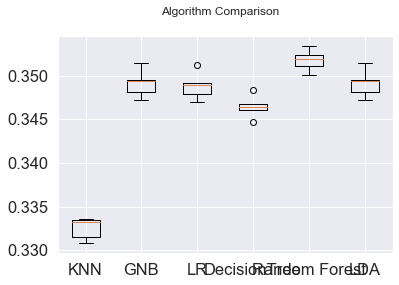

In [31]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results1)
ax.set_xticklabels(names)
plt.show()